In [1]:
import pandas as pd
import numpy as np
import os

#load odds and results
data = pd.read_csv('odds&results2024.csv')
abvr_match = pd.read_csv('team_abbrv_match.csv')
data = data.merge(abvr_match, left_on='home_team', right_on='team_name')
data = data.merge(abvr_match, left_on='away_team', right_on='team_name')
odds_and_results = data.rename(columns={"team_abbrv_x": "home_team_abbrv", "team_abbrv_y": "away_team_abbrv"})

#parse through raw output and add to full_list dataframe
player_list = [37,'Billiard91','Bob Z','EllieisAwesome1','JJB','JJapcon','Jack Ballard','K-Dog','Kathy Zwartz','Kkrugz','Linds Domino','Lizzy_Z','Matt McKenna','MattWojtanek','Michael Zwartz','Midway Monsters','Murr-auders','PBW','Shan-diddy','Shaner','Shumarie','TAZ','Team Boylan','TeamGalarza1020','UrBoiJZ','Zapp','abfarias','taz7611']
full_picks = pd.DataFrame() 

#parse all results for clean data file
directory = os.fsencode('weekly_data\picks2024')
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    nfl_week = (filename.split(".")[0]).split("week")[1]
        
    df = pd.read_excel(f"weekly_data\picks2024\{filename}")
    df.columns.values[0] = "player" #rename column for merge

    #fill in black player names in points rows
    df.replace(" ", np.nan, inplace=True)
    df['player'] = df['player'].ffill()

    #add 'player' for home team and drop other game rows
    df['player'].fillna(value='home_team', inplace=True)
    df = df.drop(index=[0,1], columns=df.columns[-1])

    #reverse rows and columns
    df1 = df.transpose()

    # Make the first row the new column names
    df1.columns = df1.iloc[0]  # Set the new column names
    df1 = df1[1:]  # Drop the first row
    df1 = df1.reset_index(drop=True)
    df2 = df1.copy()
    df2['nfl_week'] = int(nfl_week)
    
    for player in player_list:
        if player in df2.columns:
            player_df = df2[['home_team', 'nfl_week', player]].copy()
            player_df['player'] = player
            player_df.columns.values[2] = "pick"
            player_df.columns.values[3] = "points"
            
            #append each player to the full list        
            full_picks = pd.concat([full_picks, player_df])
        
data_merged = full_picks.merge(odds_and_results, left_on=['home_team', 'nfl_week'], right_on=['home_team_abbrv', 'nfl_week'], how='left')


In [63]:
upset_counts = pd.DataFrame(columns=['week', 'upset'])
i = 1

while i <= max(odds_and_results['nfl_week']): 
    #calculate number of upsets 
    upset_table = odds_and_results[odds_and_results['nfl_week']==i].copy()

    # Count upsets
    upset_condition = ((upset_table['home_spread'] > 0) & (upset_table['home_score'] > upset_table['away_score'])) | \
                      ((upset_table['home_spread'] < 0) & (upset_table['home_score'] < upset_table['away_score']))

    upset_count = upset_condition.sum()

    upset_counts.loc[i-1] = [i, upset_count]
    
    print("Number of upsets in week", i, "-", upset_count)
    i = i + 1

Number of upsets in week 1 - 3
Number of upsets in week 2 - 8
Number of upsets in week 3 - 8
Number of upsets in week 4 - 7
Number of upsets in week 5 - 3
Number of upsets in week 6 - 0
Number of upsets in week 7 - 5


In [4]:
#create a measure for pick success (points given * point differential)
total_score = data_merged[['game','player','pick','points','nfl_week','home_team_abbrv','home_spread','away_team_abbrv','home_score','away_score']].copy()

# Create the 'winner' column
total_score['winner'] = np.where(total_score['home_score'] > total_score['away_score'], 
                        total_score['home_team_abbrv'], 
                        total_score['away_team_abbrv'])

total_score['point_diff'] = abs(total_score['home_score'] - total_score['away_score'])

# Create the 'score' column
total_score['score'] = np.where(total_score['pick'] == total_score['winner'], total_score['points'], 0)


results = total_score.groupby(['player', 'nfl_week'])[['score']].sum().reset_index()
results[results['nfl_week'] == 7].sort_values('score', ascending=False).head(5)



,player,nfl_week,score
111,Midway Monsters,7,123
76,Linds Domino,7,115
132,Shan-diddy,7,112
13,Billiard91,7,112
20,Bob Z,7,111


In [47]:
analysis = results.groupby(['nfl_week']).describe().reset_index(inplace=False)

analysis.columns = ['NFL week', 'count', 'Avg score', 'std', 'Low Score', '25%', '50%', '75%', 'High Score']

analysis['range'] = analysis['High Score'] - analysis['Low Score']
analysis


,NFL week,count,Avg score,std,Low Score,25%,50%,75%,High Score,range
0,1,28.0,102.500000,12.327326,71.0,94.00,101.5,115.00,120.0,49.0
1,2,27.0,59.333333,13.358950,33.0,51.50,58.0,64.00,97.0,64.0
2,3,28.0,56.892857,11.792462,27.0,49.75,57.5,63.00,78.0,51.0
3,4,28.0,84.535714,12.099838,58.0,76.00,86.0,93.25,103.0,45.0
4,5,28.0,71.857143,11.962021,46.0,63.50,72.5,80.25,97.0,51.0
5,6,28.0,113.071429,13.352565,84.0,106.25,116.5,123.25,133.0,49.0
6,7,28.0,95.535714,17.248687,45.0,84.25,102.0,107.25,123.0,78.0


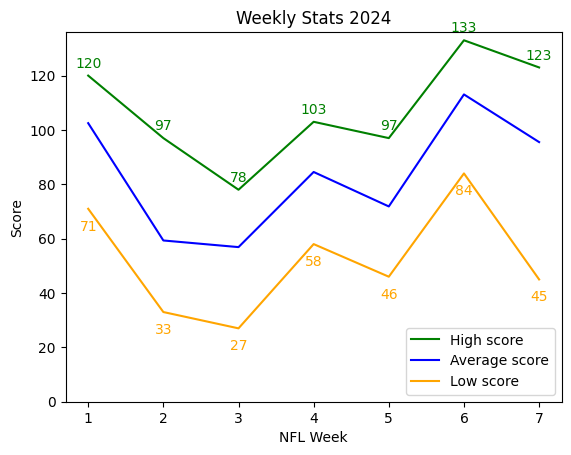

In [60]:
import matplotlib.pyplot as plt

analysis_merged = analysis.merge(upset_counts, how='left', left_on='NFL week', right_on='week')

plt.plot(analysis_merged['NFL week'], analysis_merged['High Score'], color="green", label='High score')
plt.plot(analysis_merged['NFL week'], analysis_merged['Avg score'], color="blue", label='Average score')
plt.plot(analysis_merged['NFL week'], analysis_merged['Low Score'], color="orange", label='Low score')


# Adding titles and labels
plt.title('Weekly Stats 2024')
plt.xlabel('NFL Week')
plt.ylabel('Score')
plt.xticks(analysis_merged['NFL week'])  # Set x ticks to be the same as x values
plt.ylim(0, 136)
#plt.grid()

# Adding a legend
plt.legend(loc='lower right')

#label y points
for i, v in enumerate(analysis_merged['High Score']):
    rounded_value = round(v)
    plt.text(analysis_merged['NFL week'][i], v + 3, str(rounded_value), color='green', ha='center')

# Label each data point for the second series
for i, v in enumerate(analysis_merged['Low Score']):
    rounded_value = round(v)
    plt.text(analysis_merged['NFL week'][i], v - 8, str(rounded_value), color='orange', ha='center')

# Show the plot
plt.show()

In [62]:
#pick strength rating
player_pick_strength = total_score.copy()

high_score = player_pick_strength[['game', 'nfl_week']].drop_duplicates().groupby(['nfl_week']).count().reset_index()
high_score['high_score'] = high_score['game']*(high_score['game'] + 1)/2 

max_strength = player_pick_strength[['game','nfl_week', 'point_diff']].drop_duplicates()
max_strength['point_diff_rnk'] = 17 - max_strength[['nfl_week','point_diff']].groupby('nfl_week').rank(ascending=False)

player_pick_strength=player_pick_strength.merge(max_strength[['game','point_diff_rnk']], on='game')
player_pick_strength['pick_strength_score'] = abs((player_pick_strength['score']-player_pick_strength['point_diff_rnk']))

strength_rating = player_pick_strength[['player', 'nfl_week', 'score', 'pick_strength_score']].groupby(['player', 'nfl_week']).sum().reset_index()
strength_rating = strength_rating.merge(high_score[['nfl_week', 'high_score']], on='nfl_week')
strength_rating['pick_strength_rating'] = (1 - strength_rating['pick_strength_score']/strength_rating['high_score'])*100

strength_rating[['nfl_week', 'pick_strength_rating']].groupby('nfl_week').mean()

#player_pick_strength[['player', 'nfl_week', 'score', 'pick_strength_score']].query('nfl_week == 6 & (player == "Bob Z" | player == "taz7611")')
#strength_rating[['player', 'score', 'pick_strength_rating']][strength_rating['nfl_week'] == 7].sort_values('pick_strength_rating', ascending=False).round().head(10)

,pick_strength_rating
nfl_week,
1,22.899160
2,19.063181
3,24.789916
4,25.236345
5,18.014129
6,30.510204
7,30.892857
